In [1]:
suppressPackageStartupMessages(library("affy"))
suppressPackageStartupMessages(library("affyio"))


################################ functions ##########################################

# download and install BrainArray files 

getBrainArrayFile <-  function(chipname,what,version="22.0.0",gene_id_type="ensg", download_dir=getwd()){
    fname <- paste0(chipname,gene_id_type,what,"_",version,".tar.gz")
    link <- paste0("http://mbni.org/customcdf/",version,"/",gene_id_type,".download/",fname)
    #print(link)
    fpath <- paste0(download_dir,fname)
    download.file(link, destfile = fpath, method = "wget")
    suppressWarnings(install.packages(fpath, repos = NULL, type="source"))
    libname <- paste0(chipname,gene_id_type,what)
    suppressPackageStartupMessages(library(libname,character.only = T))
    return(libname)
}
# for Ensembl:
# entrezg -> ensg
# .db -> probe
installBrainArrayCDFandDB <- function(chipname,version="22.0.0",gene_id_type="entrezg", download_dir=getwd()){
    customCDFname <- getBrainArrayFile(chipname,"cdf",version=version,
                            gene_id_type=gene_id_type, download_dir=download_dir)
    # the same way for probe file
    
    customDBname <- getBrainArrayFile(chipname,".db",version=version,
                                   gene_id_type=gene_id_type, download_dir=download_dir)
    return (list(customCDFname=customCDFname, customDBname = customDBname))
}



# The effect of CDF and annotation on the results of affy:justRMA()

#### Threre are two crucial reference files required to preprocess raw microarray data, i.e. to get gene expression profiels from .CEL files:

* CDF file (or more precisely the environment generated from the source file) defines how probes unitied into probesets and stores probe location to probeset mapping. In Affymetrix microarrays each probeset includes ~10-20 oligonucleotide probes. Some of them are not specific enough or designed for QC (starting with "AFFX") and therefore are not suitable for gene expression  estimation. Different CDFs edfine sligtly different mapping with completely different probe names. 

Options:
 - AnnotationDbi. By default affy imports CDF environments from http://master.bioconductor.org/packages/release/data/annotation/.
 - BrainArray provides updated probeset definition (current v22.0.0, Jun 21, 2017) correponding to the latest genome and transcriptome assemblies, when Affymetrix definition may be outdated. The impact of CDF on the result of differential expression analysis may be high:
 https://onlinelibrary.wiley.com/doi/abs/10.1002/bies.20433
 https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-48


* Annotation file of DB contains probeset IDs mapping to gene or transcript IDs. Since for some genes more than one probeset exist, per gene expression is computed as an average over probesets belonging to the same gene.
Options:
 - AnnotationDbi - annotation is missing for HuGene-1_0-st-v1 platform.
 - BrainArray DB - covers approximately 100 unique genes momre than AnnotationDbi
 - biomaRt - allows to select a specific Ensemble version, e.g. 37.75. Ensemble describes their own pipeline of probe-to-gene mapping https://uswest.ensembl.org/info/genome/microarray_probe_set_mapping.html. No annotation for HGU-219 platform. 
 
### Selection of gene nomenclature
Options:
 - HGNC gene Symbols
     + human-readble
     - not stable; IL8 can be changed to CXCL8; ~10% of IDs from PDX do not map on the current HGNC. 
     + despite that, in many studies gene symbols are the only IDs reported. PDX reports only gene symbols in expression and CNA data tables. 
     - many IDs do not correspond to genes but to loci associated with a phenotype; this is very cofusing for transcriptomics. At the same time, many RNAs and pseudogenes are not presented in this nomenclature.     
 - Entrez IDs
     + numeric gene IDs, seem to be more stable
     - not human-readable
     
 - ENSEMBL IDs
     + these ids correspond to a certain transcriptome assembly, so there are no loci and there are non-coding RNA
     - BrainArray and AnnotationDbi mappings to Ensemble mixing up ENSEMBL IDs from Grch37 and Grch38, athough here https://www.sciencedirect.com/science/article/pii/S1535610817302532 BrainArray CDF was used together with transcriptome annotation 
 
# Conclusions
in the current version we use: 
 - the latest CDF from BrainArray 
and 
 - BrainArray annotation to map probesets to Entrez gene IDs, since they are more stable than HGNC. 
 
In general, for transcriptomic and proteomic studies Ensembl nomencalture would be more appropriate, because it covers more transcripts, do not include "phenotype only" loci and allows to control assembe versions. However,  both BrainArray and AnnotationDbi some microarray probes mapped to multiple Ensembl IDs due to mixing up 37th and 38th assmblies. 
BiomaRt developed by Ensembl would be an alternative soution, but GDSC, a key dataset for our study, is profiled by affymetrix HGU-219 platform, absent in biomaRt. 


# To Do:
- try RMA vs gcRMA vs MAS5 normalizations
- perform QC 

### Statistics of gene annotations in BrainArray
"hgu219hs","hgu133plus2hs","hgu95av2hs","hgu133ahs","hgu133bhs","hugene10sths"


In [2]:
# how many unique gene ids in each annotation
for (platform in c("hgu219hs","hgu133plus2hs","hgu95av2hs","hgu133ahs","hgu133bhs","hugene10sths")){
    customAnno <- installBrainArrayCDFandDB(platform,version='22.0.0',gene_id_type="entrezg",
                                        download_dir="/home/olya/SFU/Hossein/arrays/")
    anno_ENTR <- suppressMessages(select(get(customAnno$customDBname), keytype="PROBEID", 
  columns=c("ENTREZID"), keys=keys(get(customAnno$customDBname))))
    anno_ENS <- suppressMessages(select(get(customAnno$customDBname), keytype="PROBEID", 
  columns=c("ENSEMBL"), keys=keys(get(customAnno$customDBname))))
    anno_SYM <- suppressMessages(select(get(customAnno$customDBname), keytype="PROBEID", 
  columns=c("SYMBOL"), keys=keys(get(customAnno$customDBname))))
    cat(paste(platform,"ENTREZ",length(unique(anno_ENTR$ENTREZID)),
                "ENSEMBL",length(unique(anno_ENS$ENSEMBL)),"ENSEMBL dups",
                length(duplicated(anno_ENS$PROBEID)),
                "SYMBOL",length(unique(anno_SYM$SYMBOL)),"\n",sep="    "))
    
}

hgu219hs    ENTREZ    18646    ENSEMBL    20342    ENSEMBL dups    20757    SYMBOL    18646    
hgu133plus2hs    ENTREZ    20343    ENSEMBL    20928    ENSEMBL dups    22473    SYMBOL    20343    
hgu95av2hs    ENTREZ    8450    ENSEMBL    9443    ENSEMBL dups    9554    SYMBOL    8450    
hgu133ahs    ENTREZ    12250    ENSEMBL    13538    ENSEMBL dups    13842    SYMBOL    12250    
hgu133bhs    ENTREZ    9074    ENSEMBL    8887    ENSEMBL dups    9671    SYMBOL    9074    
hugene10sths    ENTREZ    20663    ENSEMBL    21371    ENSEMBL dups    22943    SYMBOL    20663    


# Here we show, that our microarray preprocessing pipeline produces almost the same results as in He et al. 2018:
https://academic.oup.com/bioinformatics/article/34/16/2808/4924716
by Xiao He, Lukas Folkman and Karsten Borgwardt 

For that we preprocess raw expression data from GDSC and GSE (docetaxel clinica trials) and compare it with expression profiles provided by Lukas Folkman



##  Preprocess raw GDSC data from E-MTAB-3610 with BrainArray CDF and DB
  * get platform names from CEL headers
  * download and install corresponding BrainArray CDF and DB
  * read full CEL files affy::justRMA() with specified cdfname ( hus we replace the default CDF with custom CDF from BrainArray); justRMA sumarizes CEL intensities according to provided CDF, bg-corrects, RMA-normalizes and log2-transforms.   
  
 [docs. : "cdfname If set to NULL, then the usual cdf package based on Affymetrix' mappings will be used."]
 According to affy manual, default CDF are taken from here: http://bioconductor.org/help/bioc-views/release/data/annotation/ (and most of them are AnnotationDbi packages)
 


In [3]:
cel_file_dir = "arrays/E-MTAB-3610/"
getSnames <- function(sname,ext=".cel"){
    sname <- sub(ext, "", sname)
    sname <- unlist(sname)[1]
    return(sname)
}
fnames <- list.files(cel_file_dir ,pattern = ".cel")
snames <- lapply(fnames, getSnames)
snames <- unlist(snames)
# number of CEL files:
length(snames)
#get CDF names from platform names from CEL headers 
getCDFname <- function(fname,dir=getwd()){
    cel_header <-affyio::read.celfile.header(paste0(dir,fname))
    return(cleancdfname(cel_header$cdfName))
}
cdf_basenames <- unique(unlist(lapply(fnames,getCDFname, dir=cel_file_dir)))
cdf_basenames 
# add processing of batches in future
cdf_basename <- sub("cdf","",cdf_basenames[1])

# load BrainArray
customAnno <- installBrainArrayCDFandDB(paste0(cdf_basename,"hs"),version='22.0.0',gene_id_type="entrezg",
                                        download_dir="/home/olya/SFU/Hossein/arrays/")
#customAnno

[1] 1018

[1] "hgu219cdf"

In [4]:
GDSC_rma_ba <- affy::justRMA(celfile.path="arrays/E-MTAB-3610/",filenames = fnames,sampleNames=snames,
                     verbose=FALSE,compress=FALSE,cdfname=customAnno$customCDFname)
#GDSC_rma_ba
dim(exprs(GDSC_rma_ba))
head(exprs(GDSC_rma_ba))

ExpressionSet (storageMode: lockedEnvironment)
assayData: 18653 features, 1018 samples 
  element names: exprs, se.exprs 
protocolData
  sampleNames: 5500994157493061613625_A01 5500994157493061613625_A02
    ... 5500994175999120813240_H11 (1018 total)
  varLabels: ScanDate
  varMetadata: labelDescription
phenoData
  sampleNames: 5500994157493061613625_A01 5500994157493061613625_A02
    ... 5500994175999120813240_H11 (1018 total)
  varLabels: sample
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation: hgu219hsentrezgcdf 

,5500994157493061613625_A01,5500994157493061613625_A02,5500994157493061613625_A03,5500994157493061613625_A04,5500994157493061613625_A05,5500994157493061613625_A06,5500994157493061613625_A07,5500994157493061613625_A08,5500994157493061613625_A09,5500994157493061613625_A10,⋯,5500994175999120813240_H02,5500994175999120813240_H03,5500994175999120813240_H04,5500994175999120813240_H05,5500994175999120813240_H06,5500994175999120813240_H07,5500994175999120813240_H08,5500994175999120813240_H09,5500994175999120813240_H10,5500994175999120813240_H11
1_at,6.210671,5.029226,5.513632,4.208249,3.402282,4.914035,3.827411,5.147878,3.110751,5.054884,⋯,4.273165,3.442682,4.923977,2.901377,4.528475,5.079415,2.959578,3.094308,4.045297,5.339831
10_at,3.091616,2.925953,3.186898,3.090349,5.070067,2.912126,3.028838,3.049457,2.996803,3.487389,⋯,3.169651,3.094766,2.978914,3.312476,3.271839,3.004895,3.039933,3.346097,3.049132,3.238387
100_at,8.956673,7.687656,7.944700,9.259829,7.017582,6.905274,9.751193,7.540148,5.773222,3.324055,⋯,6.993797,8.793967,11.941098,9.371423,7.939735,9.046963,6.055670,7.746151,6.814890,5.698509
1000_at,7.613752,3.066216,6.634775,8.708245,8.754138,6.827789,3.282731,8.739057,9.572730,3.037323,⋯,3.816762,3.022264,5.862574,6.649221,8.565891,6.079522,4.536474,4.141976,8.703439,4.722706
10000_at,5.836163,4.045650,2.832221,4.290599,4.776181,4.715363,3.575370,4.213761,5.838059,2.894429,⋯,5.388321,2.827153,3.599740,5.266808,3.960827,5.060720,5.723751,3.494836,3.297643,5.769323
10001_at,6.927791,7.396852,7.097197,7.389636,8.015398,7.107112,7.659327,6.855786,7.808900,7.290094,⋯,7.876365,8.314665,8.197616,7.431327,8.092348,6.973491,8.852970,8.436557,7.824003,7.584112


In [10]:
diagnose_annotation <- function(anno,drop_NA=TRUE){
    
    cat(paste(sum(is.na(anno[,1])),sum(is.na(anno[,2])),
            "NA values in columns",colnames(anno)[1],colnames(anno)[2],"\n",sep="    "))
    a <- anno[!is.na(anno[,2]),]
    cat(paste(dim(a)[1],"rows remain after removing NA from ",colnames(anno)[2],"\n",sep="    "))
    dups <- unique(a[,1][duplicated(a[,1])])
    cat(paste("duplicates in column",colnames(a)[1], length(dups),"\n",sep="    "))
    dup_probes <- unique(a[,2][duplicated(a[,2])])
    cat(paste("duplicates in column",colnames(a)[2], length(dup_probes),"\n",sep="    "))
    cat(paste("unique genes",length(unique(a[,2])),"\n",sep="    "))
    if (drop_NA){
        # drop unmapped probes with NA gene IDs
        anno <- anno[!is.na(anno[,2]),]
        return(anno)
    }
    else{
        return(anno)
    }
}
anno_ENTREZID <- select(get(customAnno$customDBname), keytype="PROBEID", 
  columns=c("ENTREZID"), keys=row.names(exprs(GDSC_rma_ba)))
anno_ENTREZID <- diagnose_annotation(anno_ENTREZID)
dim(anno_ENTREZID)
anno_SYMBOL <- select(get(customAnno$customDBname), keytype="PROBEID", 
  columns=c("SYMBOL"), keys=row.names(exprs(GDSC_rma_ba)))
anno_SYMBOL <- diagnose_annotation(anno_SYMBOL)

'select()' returned 1:1 mapping between keys and columns


0    8    NA values in columns    PROBEID    ENTREZID    
18645    rows remain after removing NA from     ENTREZID    
duplicates in column    PROBEID    0    
duplicates in column    ENTREZID    0    
unique genes    18645    


[1] 18645     2

'select()' returned 1:1 mapping between keys and columns


0    8    NA values in columns    PROBEID    SYMBOL    
18645    rows remain after removing NA from     SYMBOL    
duplicates in column    PROBEID    0    
duplicates in column    SYMBOL    0    
unique genes    18645    


### Annotate probesets with genes and summarize to gene level
- Use Entrez gene IDs
- Apply WGCNA::collapseRows(method="Average")
- write to file

In [12]:
# actually, no CollapseRows() needed here, because these mappings are one-to-one
CR <- WGCNA::collapseRows(exprs(GDSC_RMA_BrainArray), rowGroup = anno_ENTREZID$ENTREZID,
                          rowID = anno_ENTREZID$PROBEID,method="Average")
exprs_GDSC_RMA_BrainArray_ENTREZ <- CR$datETcollapsed

# the same for SYMBOL
CR <- WGCNA::collapseRows(exprs(GDSC_RMA_BrainArray), rowGroup = anno_SYMBOL$SYMBOL,
                          rowID = anno_SYMBOL$PROBEID,method="Average")
exprs_GDSC_RMA_BrainArray_SYMBOL <- CR$datETcollapsed

dim(exprs_GDSC_RMA_BrainArray_SYMBOL)
head(exprs_GDSC_RMA_BrainArray_SYMBOL)
write.table(exprs_GDSC_RMA_BrainArray_SYMBOL, file ="Geeleher_with_GDSCr6/data/GDSC_micro.BrainArray.RMAlog2Average.Symbol.Expr.tsv"
            ,na="",quote = FALSE,sep="\t")
write.table(exprs_GDSC_RMA_BrainArray_ENTREZ, file ="Geeleher_with_GDSCr6/data/GDSC_micro.BrainArray.RMAlog2Average.Entrez.Expr.tsv"
            ,na="",quote = FALSE,sep="\t")

[1] 18645  1018

,5500994157493061613625_A01,5500994157493061613625_A02,5500994157493061613625_A03,5500994157493061613625_A04,5500994157493061613625_A05,5500994157493061613625_A06,5500994157493061613625_A07,5500994157493061613625_A08,5500994157493061613625_A09,5500994157493061613625_A10,⋯,5500994175999120813240_H02,5500994175999120813240_H03,5500994175999120813240_H04,5500994175999120813240_H05,5500994175999120813240_H06,5500994175999120813240_H07,5500994175999120813240_H08,5500994175999120813240_H09,5500994175999120813240_H10,5500994175999120813240_H11
A1BG,6.210671,5.029226,5.513632,4.208249,3.402282,4.914035,3.827411,5.147878,3.110751,5.054884,⋯,4.273165,3.442682,4.923977,2.901377,4.528475,5.079415,2.959578,3.094308,4.045297,5.339831
A1CF,2.986196,2.952698,2.876904,3.078416,2.859689,3.226181,3.002562,2.899220,2.761808,2.991242,⋯,2.948285,3.162107,2.989301,3.122200,2.981742,2.912033,2.950125,2.788239,2.874734,2.930411
A2M,3.138822,3.339745,3.288143,3.035124,3.266711,6.878105,3.306808,3.376042,3.326467,3.532250,⋯,3.898669,3.478617,3.251410,6.346759,3.532383,3.161646,3.203922,3.483303,5.147751,8.860099
A2ML1,2.659014,2.740146,3.941870,2.782538,2.716182,2.912234,2.791071,2.829216,2.736346,2.977346,⋯,2.904620,2.795384,2.714010,2.835382,2.763315,2.752095,2.911493,2.920386,2.794910,2.991144
A3GALT2,2.765093,2.871171,3.009816,2.634662,2.697715,2.593990,2.929163,2.744387,2.998624,3.043765,⋯,2.964269,3.067023,2.768809,2.607127,2.778964,2.850118,2.703913,2.663925,2.763491,2.604637
A4GALT,3.342432,3.138229,3.513538,3.166587,3.240146,3.246475,3.801788,3.377124,3.288002,3.361292,⋯,3.384112,3.070601,2.986975,3.334498,3.398661,3.195717,3.277447,4.407162,3.008970,3.053538


## Compare with Lukas's data 

In [15]:
GEX <- read.csv("Geeleher_with_GDSCr6/data/GEX.csv",row.names=1,header = T)
dim(GEX)
head(GEX)

[1] 17419   962

,CAL.120,DMS.114,CAL.51,H2869,H290,A2058,CESS,H2803,H2722,HCC1419,⋯,SW1271,NCI.H716,LB831.BLC,HC.1,Jurkat,MOG.G.UVW,JIMT.1,PEO1,PL4,TT
TSPAN6,7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,6.961606,5.943046,3.455951,⋯,6.287819,3.607123,7.105637,3.236503,3.038892,8.373223,8.441628,8.422922,8.089255,3.112333
TNMD,2.964585,2.777716,2.643508,2.817923,2.957739,2.889677,2.828203,2.874751,2.686874,3.290184,⋯,2.842090,2.866483,2.798847,2.745137,2.976406,2.852552,2.639276,2.879890,2.521169,2.870468
DPM1,10.379553,11.807341,9.880733,9.883471,10.418840,9.773987,10.264385,10.205931,10.299757,11.570155,⋯,10.370130,10.246750,10.486486,10.442951,10.311962,10.454830,11.463742,10.557777,10.792750,9.873902
SCYL3,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,3.715033,3.848112,5.560883,⋯,3.789814,3.780485,3.696835,4.624013,4.348524,3.858121,4.425849,3.550390,4.443337,4.266828
C1orf112,3.380681,3.732485,3.236620,3.558414,3.840373,3.815055,3.011867,3.268449,3.352835,3.571228,⋯,3.318119,3.499160,3.726833,3.947744,3.806584,3.196988,4.384732,4.247189,3.071359,3.230197
FGR,3.324692,3.152404,3.241246,3.101247,3.001802,3.298915,9.565308,3.036333,3.278688,3.370885,⋯,3.154849,3.056503,3.245301,8.969347,3.562548,3.098083,3.229511,3.176336,3.238305,3.027742


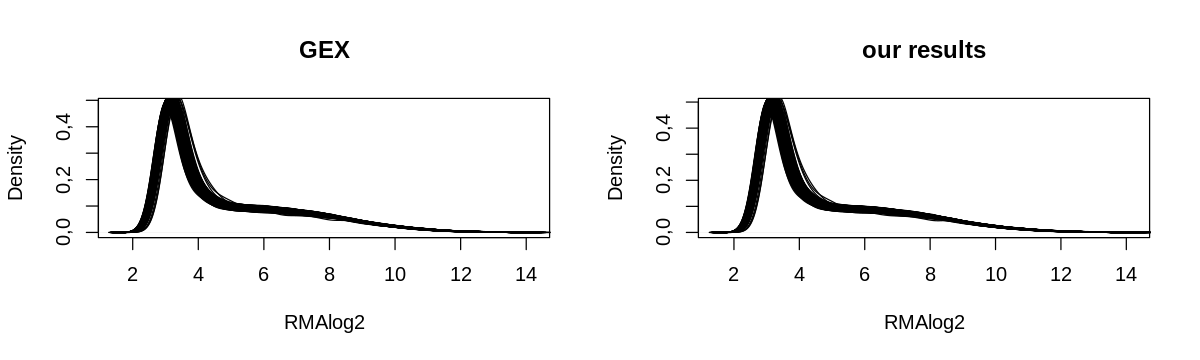

In [18]:
myhist <- function(expr,title = "Histogram", xlabel = "RMAlog2"){
 i=1 
 plot( density(expr[,i]),main = title, xlab=xlabel)
 for(i in 2:dim(expr)[2]){
  lines(density((expr[,i])))
 }
}
options(repr.plot.width=10, repr.plot.height=3)
par(mfrow = c(1,2))
myhist(GEX, title = "GEX")
myhist(exprs_GDSC_RMA_BrainArray_SYMBOL, title = "our results")

### Compare two expression marices after annotatation
(now they have mostly the same row.names)
 - find the number of rows in each and the number of shared row names 
 - correlation of gene profiles
 - correlation of sample profiles

In [67]:
# rename columns in our data table
cl_names <- read.csv("GDSC/E-MTAB-3610.annotation.tsv",header = T,sep="\t")
cl_names$Characteristics.cell.line. <- gsub("-",".",cl_names$Characteristics.cell.line.)
cl_names <- cl_names[!cl_names$Characteristics.cell.line. %in%  cl_names$Characteristics.cell.line.[duplicated(cl_names$Characteristics.cell.line. )],]
length(intersect(cl_names$Characteristics.cell.line.,colnames(GEX)))
row.names(cl_names) <- cl_names$Assay.Name
cl_names <- cl_names[colnames(exprs_GDSC_RMA_BrainArray_SYMBOL),]
cl_names <- cl_names[!is.na(cl_names$Assay.Name),]

exprs_GDSC_RMA_BrainArray_SYMBOL_ <- exprs_GDSC_RMA_BrainArray_SYMBOL[,cl_names$Assay.Name]
colnames(exprs_GDSC_RMA_BrainArray_SYMBOL_) <- cl_names$Characteristics.cell.line.
head(exprs_GDSC_RMA_BrainArray_SYMBOL_)

,5500994157493061613625_A01,5500994157493061613625_A02,5500994157493061613625_A03,5500994157493061613625_A04,5500994157493061613625_A05,5500994157493061613625_A06,5500994157493061613625_A07,5500994157493061613625_A08,5500994157493061613625_A09,5500994157493061613625_A10,⋯,5500994175999120813240_H02,5500994175999120813240_H03,5500994175999120813240_H04,5500994175999120813240_H05,5500994175999120813240_H06,5500994175999120813240_H07,5500994175999120813240_H08,5500994175999120813240_H09,5500994175999120813240_H10,5500994175999120813240_H11
A1BG,"6,210671","5,029226","5,513632","4,208249","3,402282","4,914035","3,827411","5,147878","3,110751","5,054884",⋯,"4,273165","3,442682","4,923977","2,901377","4,528475","5,079415","2,959578","3,094308","4,045297","5,339831"
A1CF,"2,986196","2,952698","2,876904","3,078416","2,859689","3,226181","3,002562","2,899220","2,761808","2,991242",⋯,"2,948285","3,162107","2,989301","3,122200","2,981742","2,912033","2,950125","2,788239","2,874734","2,930411"
A2M,"3,138822","3,339745","3,288143","3,035124","3,266711","6,878105","3,306808","3,376042","3,326467","3,532250",⋯,"3,898669","3,478617","3,251410","6,346759","3,532383","3,161646","3,203922","3,483303","5,147751","8,860099"
A2ML1,"2,659014","2,740146","3,941870","2,782538","2,716182","2,912234","2,791071","2,829216","2,736346","2,977346",⋯,"2,904620","2,795384","2,714010","2,835382","2,763315","2,752095","2,911493","2,920386","2,794910","2,991144"
A3GALT2,"2,765093","2,871171","3,009816","2,634662","2,697715","2,593990","2,929163","2,744387","2,998624","3,043765",⋯,"2,964269","3,067023","2,768809","2,607127","2,778964","2,850118","2,703913","2,663925","2,763491","2,604637"
A4GALT,"3,342432","3,138229","3,513538","3,166587","3,240146","3,246475","3,801788","3,377124","3,288002","3,361292",⋯,"3,384112","3,070601","2,986975","3,334498","3,398661","3,195717","3,277447","4,407162","3,008970","3,053538"


[1] 934

,Assay.Name,Characteristics.cell.line.
5500994157493061613625_A01,5500994157493061613625_A01,CAL.120
5500994157493061613625_A02,5500994157493061613625_A02,DMS.114
5500994157493061613625_A03,5500994157493061613625_A03,CAL.51
5500994157493061613625_A04,5500994157493061613625_A04,H2869
5500994157493061613625_A05,5500994157493061613625_A05,H290
5500994157493061613625_A06,5500994157493061613625_A06,A2058


,Assay.Name,Characteristics.cell.line.
5500994175999120813240_H05,5500994175999120813240_H05,MOG.G.UVW
5500994175999120813240_H06,5500994175999120813240_H06,MET.2B
5500994175999120813240_H07,5500994175999120813240_H07,JIMT.1
5500994175999120813240_H08,5500994175999120813240_H08,PEO1
5500994175999120813240_H09,5500994175999120813240_H09,PL4
5500994175999120813240_H10,5500994175999120813240_H10,TT


,5500994157493061613625_A01,5500994157493061613625_A02,5500994157493061613625_A03,5500994157493061613625_A04,5500994157493061613625_A05,5500994157493061613625_A06,5500994157493061613625_A07,5500994157493061613625_A08,5500994157493061613625_A09,5500994157493061613625_A10,⋯,5500994175999120813240_H01,5500994175999120813240_H02,5500994175999120813240_H03,5500994175999120813240_H04,5500994175999120813240_H05,5500994175999120813240_H06,5500994175999120813240_H07,5500994175999120813240_H08,5500994175999120813240_H09,5500994175999120813240_H10
A1BG,"6,210671","5,029226","5,513632","4,208249","3,402282","4,914035","3,827411","5,147878","3,110751","5,054884",⋯,"3,853365","4,273165","3,442682","4,923977","2,901377","4,528475","5,079415","2,959578","3,094308","4,045297"
A1CF,"2,986196","2,952698","2,876904","3,078416","2,859689","3,226181","3,002562","2,899220","2,761808","2,991242",⋯,"7,746021","2,948285","3,162107","2,989301","3,122200","2,981742","2,912033","2,950125","2,788239","2,874734"
A2M,"3,138822","3,339745","3,288143","3,035124","3,266711","6,878105","3,306808","3,376042","3,326467","3,532250",⋯,"3,801339","3,898669","3,478617","3,251410","6,346759","3,532383","3,161646","3,203922","3,483303","5,147751"
A2ML1,"2,659014","2,740146","3,941870","2,782538","2,716182","2,912234","2,791071","2,829216","2,736346","2,977346",⋯,"2,788015","2,904620","2,795384","2,714010","2,835382","2,763315","2,752095","2,911493","2,920386","2,794910"
A3GALT2,"2,765093","2,871171","3,009816","2,634662","2,697715","2,593990","2,929163","2,744387","2,998624","3,043765",⋯,"2,579725","2,964269","3,067023","2,768809","2,607127","2,778964","2,850118","2,703913","2,663925","2,763491"
A4GALT,"3,342432","3,138229","3,513538","3,166587","3,240146","3,246475","3,801788","3,377124","3,288002","3,361292",⋯,"3,378919","3,384112","3,070601","2,986975","3,334498","3,398661","3,195717","3,277447","4,407162","3,008970"


,CAL.120,DMS.114,CAL.51,H2869,H290,A2058,CESS,H2803,H2722,HCC1419,⋯,NCI.H716,LB831.BLC,HC.1,JURKAT,MOG.G.UVW,MET.2B,JIMT.1,PEO1,PL4,TT
A1BG,"6,210671","5,029226","5,513632","4,208249","3,402282","4,914035","3,827411","5,147878","3,110751","5,054884",⋯,"3,853365","4,273165","3,442682","4,923977","2,901377","4,528475","5,079415","2,959578","3,094308","4,045297"
A1CF,"2,986196","2,952698","2,876904","3,078416","2,859689","3,226181","3,002562","2,899220","2,761808","2,991242",⋯,"7,746021","2,948285","3,162107","2,989301","3,122200","2,981742","2,912033","2,950125","2,788239","2,874734"
A2M,"3,138822","3,339745","3,288143","3,035124","3,266711","6,878105","3,306808","3,376042","3,326467","3,532250",⋯,"3,801339","3,898669","3,478617","3,251410","6,346759","3,532383","3,161646","3,203922","3,483303","5,147751"
A2ML1,"2,659014","2,740146","3,941870","2,782538","2,716182","2,912234","2,791071","2,829216","2,736346","2,977346",⋯,"2,788015","2,904620","2,795384","2,714010","2,835382","2,763315","2,752095","2,911493","2,920386","2,794910"
A3GALT2,"2,765093","2,871171","3,009816","2,634662","2,697715","2,593990","2,929163","2,744387","2,998624","3,043765",⋯,"2,579725","2,964269","3,067023","2,768809","2,607127","2,778964","2,850118","2,703913","2,663925","2,763491"
A4GALT,"3,342432","3,138229","3,513538","3,166587","3,240146","3,246475","3,801788","3,377124","3,288002","3,361292",⋯,"3,378919","3,384112","3,070601","2,986975","3,334498","3,398661","3,195717","3,277447","4,407162","3,008970"


In [68]:
paste("our data",dim(exprs_GDSC_RMA_BrainArray_SYMBOL_)[1], sep ="    ")
paste("GEX",dim(GEX)[1], sep ="    ")
shared_genes <- intersect(row.names(GEX),row.names(exprs_GDSC_RMA_BrainArray_SYMBOL_))
shared_samples <- intersect(colnames(GEX),colnames(exprs_GDSC_RMA_BrainArray_SYMBOL_))
paste("Intersection: Shared Genes",length(shared_genes),"Shared samples",length(shared_samples),sep="    ")

[1] "our data    18645"

[1] "GEX    17419"

[1] "Intersection: Shared Genes    16639    Shared samples    934"

In [69]:
gene_corrs <- diag(cor(t(GEX[shared_genes,shared_samples]), t(exprs_GDSC_RMA_BrainArray_SYMBOL_[shared_genes,shared_samples])))
sample_corrs <- diag(cor(GEX[shared_genes,shared_samples], exprs_GDSC_RMA_BrainArray_SYMBOL_[shared_genes,shared_samples]))

### Result:
* Correlation between samples is nearly perfect: 0.981-0.977, 0.98 on average;
* Gene profile correlation is also good for most genes (0.99 on average), but for some it is very poor: min. is -0.04

In [79]:
# average correlation between genes 
paste("Corr. between genes (mean, max, min)",mean(gene_corrs),max(gene_corrs),min(gene_corrs), sep ="    ")
# average correlation between samples
paste("Corr. between samples (mean, max, min)",mean(sample_corrs),max(sample_corrs),min(sample_corrs), sep ="    ")

[1] "Corr. between genes (mean, max, min)    0,987574861022879    0,999999501930154    -0,0466895425476415"

[1] "Corr. between samples (mean, max, min)    0,97923761177824    0,980946265835985    0,977003232824752"

In [80]:
# top 20 genes with the worst correlation 
head(sort(gene_corrs,decreasing = FALSE),20)

NDUFA13         AGRN      CCDC122        AKTIP         TET3       EXOSC7 
-0,046689543 -0,035771796 -0,005483214  0,018462202  0,081497933  0,093252962 
     STARD10        NAA38        EFR3B        SPIN3        SMCR8       HS6ST3 
 0,118468068  0,120170348  0,126137220  0,150719264  0,158261242  0,196708978 
       OFCC1        RPL10        DLEU2        KLHL7        PPM1E         MKL2 
 0,213518347  0,245640291  0,250760460  0,259364035  0,264811048  0,268757227 
       DISC1      C3orf30 
 0,290808336  0,303613400

In [81]:
length(gene_corrs[gene_corrs<0.9])

[1] 587

# Compare expressions provided by Lukas Folkman with our results 


### GSE6434
Resulted correlation of sample profiles for GSE6434

In [99]:
load("Geeleher_with_GDSCr6/data/doce_rma_syms_brainArray.RData",verbose = T)

Loading objects:
  doceVivoNorm_syms
  groupMembership


In [100]:
dim(doceVivoNorm_syms)
colnames(doceVivoNorm_syms) <- gsub(".CEL","",colnames(doceVivoNorm_syms))
head(doceVivoNorm_syms)

[1] 8399   24

,GSM4903,GSM4907,GSM4908,GSM4914,GSM4915,GSM4917,GSM4919,GSM4920,GSM4921,GSM4923,⋯,GSM4906,GSM4909,GSM4910,GSM4911,GSM4912,GSM4913,GSM4916,GSM4918,GSM4922,GSM4924
AKT3,"4,471063","4,624944","4,692121","4,466994","5,754121","4,554908","5,429423","4,312592","4,582778","4,528860",⋯,"4,815075","4,543328","4,204645","4,361776","5,068274","4,937692","4,759488","4,357240","4,177261","4,285073"
MED6,"3,839062","3,584472","3,326740","3,535239","3,742069","3,774019","3,677544","3,898045","3,855050","3,555893",⋯,"3,364237","3,667986","3,521200","3,502689","3,351606","3,525377","3,429070","3,956674","4,073611","3,682697"
NR2E3,"7,290057","7,399590","7,468425","7,677972","7,797163","8,160049","7,042885","7,989204","7,698802","7,518574",⋯,"7,511533","8,709372","8,222946","7,912787","7,671314","7,479153","8,212303","8,233507","7,851094","8,244293"
NAALAD2,"3,242835","3,710604","3,535582","4,681849","4,179551","3,944334","3,007184","4,539145","3,058529","4,224176",⋯,"4,132053","6,250989","4,565469","4,741568","3,704555","3,302500","4,680904","5,732379","4,786829","4,913436"
NAALADL1,"4,458982","4,539672","4,233429","4,309195","4,778892","4,536552","4,131638","4,760834","4,371971","4,365722",⋯,"4,455732","5,010709","4,587314","4,458041","4,298968","4,551020","4,380551","4,852454","4,650280","4,854401"
ACOT8,"5,100625","5,307493","5,405129","5,246431","5,714727","5,812253","5,115640","5,806674","5,922718","5,290012",⋯,"5,636612","6,111452","5,990468","5,492492","5,349489","5,440780","5,528125","5,955764","5,688114","5,585995"


In [83]:
cel_file_dir = "arrays/GSE6434/"
getSnames <- function(sname,ext=".CEL.gz"){
    sname <- sub(ext, "", sname)
    #sname <- strsplit(sname,split="_")
    sname <- unlist(sname)[1]
    return(sname)
}
fnames <- list.files(cel_file_dir ,pattern = ".CEL.gz")
snames <- lapply(fnames, getSnames)
snames <- unlist(snames)
length(snames)
length(fnames)


cdf_basenames <- unique(unlist(lapply(fnames,getCDFname, dir=cel_file_dir)))
cdf_basenames 

cdf_basename <- sub("cdf","",cdf_basenames[1])

# load BrainArray
customAnno <- installBrainArrayCDFandDB(paste0(cdf_basename,"hs"),version='22.0.0',gene_id_type="entrezg",
                                        download_dir="/home/olya/SFU/Hossein/arrays/")

[1] 24

[1] 24

[1] "hgu95av2cdf"

In [86]:
rma_doce_BrainArray <- affy::justRMA(celfile.path=cel_file_dir,sampleNames=snames,
                     verbose=FALSE,compress=FALSE,cdfname=customAnno$customCDFname)
annotation(rma_doce_BrainArray)
dim(exprs(rma_doce_BrainArray))

[1] "hgu95av2hsentrezgcdf"

[1] 8519   24

In [94]:
anno_SYMBOL <- suppressMessages(select(get(customAnno$customDBname), keytype="PROBEID", 
  columns=c("SYMBOL"), keys=row.names(exprs(rma_doce_BrainArray))))
anno_SYMBOL <- anno_SYMBOL[!is.na(anno_SYMBOL$SYMBOL),]
CR <- WGCNA::collapseRows(exprs(rma_doce_BrainArray), rowGroup = anno_SYMBOL$SYMBOL, rowID = anno_SYMBOL$PROBEID
                   ,method="Average")
exprs_rma_doce_BrainArray<- CR$datETcollapsed
write.table(exprs_rma_doce_BrainArray, file ="Geeleher_with_GDSCr6/data/GSE6434.BrainArray.RMAlog2Average.Symbol.Expr.tsv",na="",quote = FALSE,sep="\t")
head(exprs_rma_doce_BrainArray)
dim(exprs_rma_doce_BrainArray)

,GSM4901,GSM4902,GSM4903,GSM4904,GSM4905,GSM4906,GSM4907,GSM4908,GSM4909,GSM4910,⋯,GSM4915,GSM4916,GSM4917,GSM4918,GSM4919,GSM4920,GSM4921,GSM4922,GSM4923,GSM4924
AADAC,"4,246572","3,988715","3,387175","3,692939","4,710232","3,788563","3,564630","4,843054","4,567442","4,268574",⋯,"3,992699","3,724247","3,401156","4,314926","5,820770","3,928832","3,613545","4,031425","4,874323","4,207930"
AAK1,"3,503150","3,481343","3,267147","3,799788","3,946391","3,486923","3,310952","3,370090","4,033090","3,521773",⋯,"3,365616","3,448040","3,277319","3,483527","3,256345","3,302839","3,270803","3,507228","3,485034","3,427167"
AAMP,"6,542812","6,433155","7,112246","6,726937","7,048852","6,697682","7,044337","6,983283","6,968767","6,134034",⋯,"7,542823","6,242356","7,463244","7,561346","6,944381","7,543045","7,032896","6,401135","6,753362","6,682369"
AANAT,"8,262640","7,809070","7,429048","7,881925","8,636162","7,612333","7,747587","7,630458","8,497340","7,720368",⋯,"7,899382","7,625594","7,761377","7,922388","7,437147","7,905339","7,712204","7,772773","7,795030","7,620933"
AARS,"8,715532","9,549540","8,925394","9,426015","8,139263","10,383877","10,094132","8,438800","8,857150","8,694890",⋯,"9,162233","9,401812","9,758292","8,780993","9,141654","9,511462","9,582736","8,506947","8,874166","8,419377"
AASDHPPT,"7,313638","7,208273","8,728579","7,394029","6,499497","7,896952","8,509394","7,753057","6,754180","9,084544",⋯,"7,292513","8,133136","7,531076","7,058344","7,443340","7,703600","7,198549","8,290108","8,486498","7,723431"


[1] 8449   24

In [95]:
anno_ENTREZ <- suppressMessages(select(get(customAnno$customDBname), keytype="PROBEID", 
  columns=c("ENTREZID"), keys=row.names(exprs(rma_doce_BrainArray))))
anno_ENTREZ <- anno_ENTREZ[!is.na(anno_ENTREZ$ENTREZ),]
CR <- WGCNA::collapseRows(exprs(rma_doce_BrainArray), rowGroup = anno_ENTREZ$ENTREZID,
                          rowID = anno_ENTREZ$PROBEID,method="Average")
exprs_rma_doce_BrainArray_ENTREZ<- CR$datETcollapsed
write.table(exprs_rma_doce_BrainArray_ENTREZ, file ="Geeleher_with_GDSCr6/data/GSE6434.BrainArray.RMAlog2Average.Entrez.Expr.tsv",
            na="",quote = FALSE,sep="\t")
head(exprs_rma_doce_BrainArray_ENTREZ)

,GSM4901,GSM4902,GSM4903,GSM4904,GSM4905,GSM4906,GSM4907,GSM4908,GSM4909,GSM4910,⋯,GSM4915,GSM4916,GSM4917,GSM4918,GSM4919,GSM4920,GSM4921,GSM4922,GSM4923,GSM4924
10,"3,352156","3,308508","3,096914","3,236103","3,811192","3,104723","3,081062","3,091837","3,949944","3,622625",⋯,"3,136446","3,491678","3,365999","3,622488","3,450723","3,396406","3,453915","3,612785","3,148515","3,275832"
100,"6,737301","6,659171","6,455985","6,695844","6,965612","6,603501","6,461829","6,246567","7,155956","6,826456",⋯,"6,775504","6,891247","6,983027","6,862854","6,768173","6,709703","6,484590","6,502096","6,745475","6,842699"
1000,"3,834283","3,677712","3,396575","3,723289","3,450899","3,545390","3,474213","3,298312","3,681804","3,471742",⋯,"3,329445","3,611272","3,160738","3,487775","3,264067","3,476193","3,115201","3,433925","3,154068","3,239380"
10000,"4,754271","4,496707","4,483903","4,585342","5,254096","4,824657","4,610763","4,705913","4,544194","4,187782",⋯,"5,769203","4,751104","4,562195","4,366119","5,410028","4,297884","4,593181","4,197862","4,547317","4,246281"
10001,"3,424575","3,490181","3,820446","3,465579","3,489038","3,349595","3,558470","3,299228","3,656393","3,511745",⋯,"3,746529","3,405819","3,760430","3,949115","3,669616","3,876380","3,835922","4,054287","3,528116","3,664227"
10002,"7,934315","7,757096","7,293050","7,820109","8,616442","7,514208","7,403382","7,470628","8,706345","8,217301",⋯,"7,802912","8,219931","8,165052","8,235681","7,045313","7,998694","7,701926","7,857424","7,532069","8,243082"


In [101]:
shared_genes <- intersect(row.names((exprs_rma_doce_BrainArray)),row.names(doceVivoNorm_syms))
length(shared_genes)
shared_samples <- intersect(colnames((exprs_rma_doce_BrainArray)),colnames(doceVivoNorm_syms))
length(shared_samples)

[1] 8061

[1] 24

In [102]:
gene_corrs <- diag(cor(t(exprs_rma_doce_BrainArray[shared_genes,shared_samples]), t(doceVivoNorm_syms[shared_genes,shared_samples])))
sample_corrs <- diag(cor(exprs_rma_doce_BrainArray[shared_genes,shared_samples], doceVivoNorm_syms[shared_genes,shared_samples]))
# average correlation between genes
paste("Corr. between genes (mean, max, min)",mean(gene_corrs),max(gene_corrs),min(gene_corrs), sep ="    ")
# average correlation between samples
paste("Corr. between samples (mean, max, min)",mean(sample_corrs),max(sample_corrs),min(sample_corrs), sep ="    ")

[1] "Corr. between genes (mean, max, min)    0,994214009288569    0,999999751668813    -0,0322620349274823"

[1] "Corr. between samples (mean, max, min)    0,995224019854658    0,996122633468715    0,993188134393841"

In [103]:
length(gene_corrs[gene_corrs<0.9])

[1] 116

In [104]:
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/olya/miniconda2/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=de_DE.UTF-8       
 [3] LC_TIME=de_DE.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=de_DE.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=de_DE.UTF-8          LC_NAME=de_DE.UTF-8          
 [9] LC_ADDRESS=de_DE.UTF-8        LC_TELEPHONE=de_DE.UTF-8     
[11] LC_MEASUREMENT=de_DE.UTF-8    LC_IDENTIFICATION=de_DE.UTF-8

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] hugene10sthsentrezg.db_22.0.0  hugene10sthsentrezgcdf_22.0.0 
 [3] hgu133bhsentrezg.db_22.0.0     hgu133bhsentrezgcdf_22.0.0    
 [5] hgu133ahsentrezg.db_22.0.0     hgu133ahsentrezgcdf_22.0.0    
 [7] hgu95av2hsentrezg.db_22.0.0    hgu95av2hsentrezgcdf_2